<font color=darkred>
    
# Soc220 Computational Text Analysis
## Lab 11: doc2vec
### April 19 2018

***

<img src="images/camera_obscura2.jpg", style="width: 550px"/>

***
***

What is doc2vec?

- Same logic as word2vec applied to doc level.

According to Mikolov et al. (2014), "every paragraph is mapped to a unique vector, represented by a column in matrix D and every word is also mapped to a unique vector, represented by a column in matrix W. The paragraph vector and word vectors are averaged or concatenated to predict the next word in a context...The paragraph token can be thought of as another word. It acts as a memory that remembers what is missing from the current context – or the topic of the paragraph." https://cs.stanford.edu/~quocle/paragraph_vector.pdf

- In other words: word2vec with another added contextual dimension.

word2vec, in general, requires lots of data:

- hundreds of millions of words, which is the equivalent of 1,000 books, 500,000 comments, or 4,000,000 tweets.

- doc2vec is the same, but "doc" can be anything. It's just another context specific vector encoded within the word embedding.

Arxiv paper:
https://arxiv.org/pdf/1405.4053v2.pdf

gensim dcoumentation:
https://radimrehurek.com/gensim/models/doc2vec.html

<img src="images/word2vec.png", style="width: 450px"/>

<img src="images/doc2vec.png", style="width: 450px"/>

**The endproduct is thus fundamentally the same, but with those word vectors we can also can infer a document to document level measure.**

***
***

Just like word2vec, there are two flavors.

- DBOW is exactly like CBOW: take context and predict word.
- while DM ("distributed-memory") is just like skip-gram: takes a word and tries to find associated words.

- DM is useful for rare words, while CBOW/DBOW is more computationally efficient and works better for frequent words

<img src="images/doc2vec flavors.png", style="width: 550px"/>

<font color=darkgreen>
    
### Loading data and some preprocessing

In [1]:
#
import pickle
df_texts = pickle.load(open("df_proceedings_monarch_and_date.p","rb"))

import pandas as pd
df_texts.head()

,date,monarch,text
0,1660_11,charles2,On the sixth of November the Parliament met ac...
1,1660_4,charles2,"CHARLES R."", ""Trusty, and Wellbeloved, We gree..."
2,1661_11,charles2,After a Recess of almost four Months the Parli...
3,1661_5,charles2,"On the 8th of May the new Parliament met, and ..."
4,1663_2,charles2,"On February 18, 16623. the Parliament met afte..."


In [88]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
import re

def cleaning_text(string):
    
    #no punctuation
    string = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", " ", string)
    
    #remove coding crap
    string = re.sub(r"\'s", " 's ", string)
    string = re.sub(r"\'ve", " 've ", string)
    string = re.sub(r"n\'t", " 't ", string)
    string = re.sub(r"\'re", " 're ", string)
    string = re.sub(r"\'d", " 'd ", string)
    string = re.sub(r"\.", " ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ", string)
    
    #word tokenize
    word_tokens = tokenizer.tokenize(string)
    #lowercase
    word_tokens = [token.lower() for token in word_tokens]
    
    #no stopword removal
    #word_tokens = [word for word in word_tokens if not word in stop_words]
    #no digits removal
    final_tokens = [word for word in word_tokens if not word.isdigit()]
    
    #convert back to string
    final_string = ' '.join(final_tokens)
    
    return final_string

In [89]:
# use apply to use my cleaning function to create a clean text cell:

df_texts['text_clean'] = df_texts.text.apply(cleaning_text)

In [90]:
df_texts.head()

,date,monarch,text,text_clean
0,1660_11,charles2,On the sixth of November the Parliament met ac...,on the sixth of november the parliament met ac...
1,1660_4,charles2,"CHARLES R."", ""Trusty, and Wellbeloved, We gree...",charles r trusty and wellbeloved we greet you ...
2,1661_11,charles2,After a Recess of almost four Months the Parli...,after a recess of almost four months the parli...
3,1661_5,charles2,"On the 8th of May the new Parliament met, and ...",on the 8th of may the new parliament met and t...
4,1663_2,charles2,"On February 18, 16623. the Parliament met afte...",on february the parliament met after a recess ...


#### Step 1: Create the LabeledSentence object

- gensim requires a 'LabeledSentence' data structure
- this is made up of your text as a list of tokens AND
- a list of labels to identify the documents.

- last time: a list of sentences, now a list of "labeled sentences"
- in future gensim, retitled: "TaggedDocument"
- from their github:

In [91]:
# import constructor
from gensim.models.doc2vec import LabeledSentence

# empty list
doc2vec_labeled_texts =[]

# go through my date and my clean text
for date, text in zip(df_texts.date, df_texts.text_clean):
    # append a 'LabeledSentence object which is taking in my text
    #splitting it and then we're appending my date as a list to.
    doc2vec_labeled_texts.append(LabeledSentence(
    text.split(), [date]
    ))

/Users/zwehrwein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  if sys.path[0] == '':


In [92]:
# datacheck

# first doc
doc2vec_labeled_texts[0]

# check that we got everyone
len(doc2vec_labeled_texts)

111

In [93]:
# once completed, it can be modified without having to redo the whole thing
dir(doc2vec_labeled_texts)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

#### Step 2: Build the "Vocabulary Table"

- since in each doc, we don't know the full 'population' of possible word associations, doc2vec requires a vocabulary table
- this is just a list of counts of unqiue words
- gensim programmed the vocabulary table as a method of a model

1.) So we have to specify the model we are going to run

2.) Build the vocabulary table

3.) Then run the model.

full documentation:

https://radimrehurek.com/gensim/models/doc2vec.html

In [94]:
from gensim.models import Doc2Vec

In [95]:
model = Doc2Vec(
                #ignore words w/ frequency lower than this
                min_count=5, 
                
                window=10, #the maximum distance between current and
                #predicted word in a model
                
                vector_size=100, #dimesionality of the feature vectors
                #According to Minkov, should be between 100 and 400
                
                # which higher-freq words are downsampled
                #sample = 1e-4, 
                
                # Limits RAM of total vocab
                # rule of thumb: 10 million words means 1 GB
                #max_vocab_size
                
                #specify how many training iterations to quit after
                #iter
                
                # DBOW if 0, distributed-memory if 1
                # This can drastically change results.
                #dm = 1,
    
                #min_alpha=0.025,
                
                # threads to use, check to see what your processing power is.
                workers=7)

In [96]:
# build the vocab
model.build_vocab(doc2vec_labeled_texts)

#### According to some notes online, the gensim doc2vec works better if you randomly shuffle your documents.

In [97]:
import random

random.shuffle(doc2vec_labeled_texts)

In [98]:
#datacheck

#selecting the "first year" and the tag of that year
doc2vec_labeled_texts[0][1]

['1724_1']

#### Finally! Time to run the model.

Two final parameters to specify:

- The number of times that the entire dataset is passed forward and back through the neural net (epochs)
- The number of sentences to embed for. (total_examples). Here we say to do so for the entire corpus

In [99]:
%%time


model.train(doc2vec_labeled_texts,
            epochs=10,
            total_examples=model.corpus_count)

CPU times: user 20.3 s, sys: 124 ms, total: 20.4 s
Wall time: 4.29 s


In [100]:
model.wv.most_similar('king')

[('queen', 0.7029472589492798),
 ('prince', 0.5728862285614014),
 ('duke', 0.5327771306037903),
 ('god', 0.5230969190597534),
 ('decease', 0.5199902057647705),
 ('rex', 0.4943675398826599),
 ('k', 0.48899751901626587),
 ('calvin', 0.4873802959918976),
 ('quaker', 0.4801616370677948),
 ('st', 0.47347211837768555)]

In [101]:
model.wv.most_similar('queen')

[('king', 0.7029472589492798),
 ('princess', 0.6450487971305847),
 ('marriage', 0.6334366798400879),
 ('highness', 0.6309912800788879),
 ('daughter', 0.6189798712730408),
 ('marrying', 0.6064252257347107),
 ('dutchess', 0.6047484874725342),
 ('elizabeth', 0.6030149459838867),
 ('prince', 0.5889748930931091),
 ('mary', 0.5757344961166382)]

In [102]:
# our classic case
model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.5906322598457336),
 ('declaration', 0.4515802562236786),
 ('triple', 0.44193196296691895),
 ('royal', 0.44110748171806335),
 ('marrying', 0.426647424697876),
 ('mary', 0.42203232645988464),
 ('crown', 0.42102065682411194),
 ('decease', 0.4106040596961975),
 ('princess', 0.4088228642940521),
 ('marriage', 0.4056834876537323)]

In [103]:
model.wv.most_similar('parliament')

[('parliaments', 0.6972274780273438),
 ('session', 0.5056579113006592),
 ('qualifying', 0.485962837934494),
 ('oblivion', 0.4438857138156891),
 ('prorogation', 0.44331786036491394),
 ('writs', 0.42980387806892395),
 ('burgesses', 0.42975956201553345),
 ('adjournment', 0.42878735065460205),
 ('subsequent', 0.42281630635261536),
 ('indenture', 0.41560372710227966)]

In [104]:
model.wv.most_similar('tax')

[('excise', 0.7430570721626282),
 ('landtax', 0.707030177116394),
 ('shilling', 0.6937054991722107),
 ('pound', 0.6847926378250122),
 ('lottery', 0.6660013198852539),
 ('yearly', 0.6631941795349121),
 ('commodity', 0.6611220836639404),
 ('revenue', 0.6595253348350525),
 ('deficiency', 0.6558263897895813),
 ('appropriated', 0.6545186042785645)]

In [105]:
model.wv.most_similar(positive=['war', 'tax'])

[('list', 0.6477188467979431),
 ('proportion', 0.6373991966247559),
 ('produce', 0.6349747776985168),
 ('surplus', 0.618009090423584),
 ('commodity', 0.6178314685821533),
 ('yearly', 0.6173915863037109),
 ('deficiency', 0.6155996918678284),
 ('debt', 0.6116843223571777),
 ('contracted', 0.610879123210907),
 ('revenue', 0.6066322922706604)]

#### .wv method allows us to access word2vec side, but docvecs is the document vectors

In [ ]:
# dir(model.docvecs)

In [132]:
model.docvecs.most_similar('1660_11')

[('1665_10', 0.8337963223457336),
 ('1661_11', 0.8211618661880493),
 ('1664_11', 0.8076193332672119),
 ('1661_5', 0.8071203827857971),
 ('1666_9', 0.8022227883338928),
 ('1663_2', 0.7970051765441895),
 ('1664_3', 0.7872402667999268),
 ('1660_4', 0.7744342684745789),
 ('1675_10', 0.7460875511169434),
 ('1714_8', 0.745965301990509)]

In [134]:
model.docvecs.most_similar('1689_2')

[('1690_3', 0.7807057499885559),
 ('1673_2', 0.7562481760978699),
 ('1678_10', 0.7228246927261353),
 ('1689_10', 0.6871376037597656),
 ('1697_12', 0.6674554347991943),
 ('1678_5', 0.6544146537780762),
 ('1692_11', 0.6468382477760315),
 ('1689_5', 0.6413376331329346),
 ('1695_11', 0.6393826007843018),
 ('1669_10', 0.6202444434165955)]

#### Visualizations

1. The same as before.

In [111]:
subset_token = []

for token, score in model.wv.most_similar(['crown','parliament']):
    subset_token.append(token)

In [112]:
# choose the 100 most similar to our chosen tokens
chosen_tokens = model.wv.most_similar(subset_token, topn=100)
chosen_tokens = [word for word, similarity in chosen_tokens]
#printing out the top 20 most associated
chosen_tokens[:20]

['usage',
 'crown',
 'exercise',
 'church',
 'descent',
 'established',
 'legal',
 'bulwark',
 'constitution',
 'violation',
 'ancient',
 'laws',
 'subsequent',
 'statutes',
 'magna',
 'rights',
 'manifestly',
 'realm',
 'worship',
 'governing']

In [113]:
# take our original two vectors and sort the most similar tokens
# take our original two vectors
x = [model.wv.similarity('crown', word) for word in chosen_tokens]
y = [model.wv.similarity('parliament', word) for word in chosen_tokens]

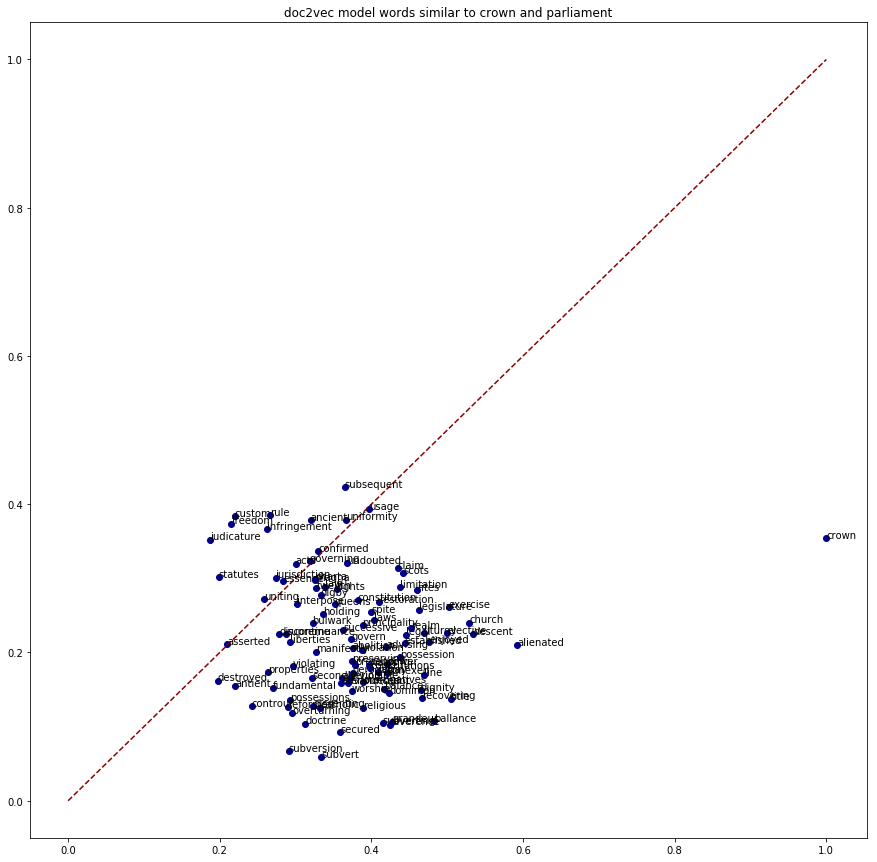

In [116]:
#same as before

import matplotlib.pyplot as plt
import matplotlib

#tell matplotlib to make a larger plot and define our axis object
plt.figure(figsize=(15,15))


#let's scatter our terms
plt.scatter(x, y, color='darkblue')

#this for loop marches through our list of tokens and adds an annotation to each value
for i in range(len(chosen_tokens)):
    plt.annotate(chosen_tokens[i], (x[i],y[i]))

#this plot places a line splitting the vector space in two
plt.plot([0, 1], [0, 1], linestyle='--', color='darkred')

#finally, let's 'zoom in' on the plot by defining limits to our x and y axis
#plt.xlim(.2,.5)
#plt.ylim(.2,.5)

plt.title('doc2vec model words similar to crown and parliament')
plt.show()


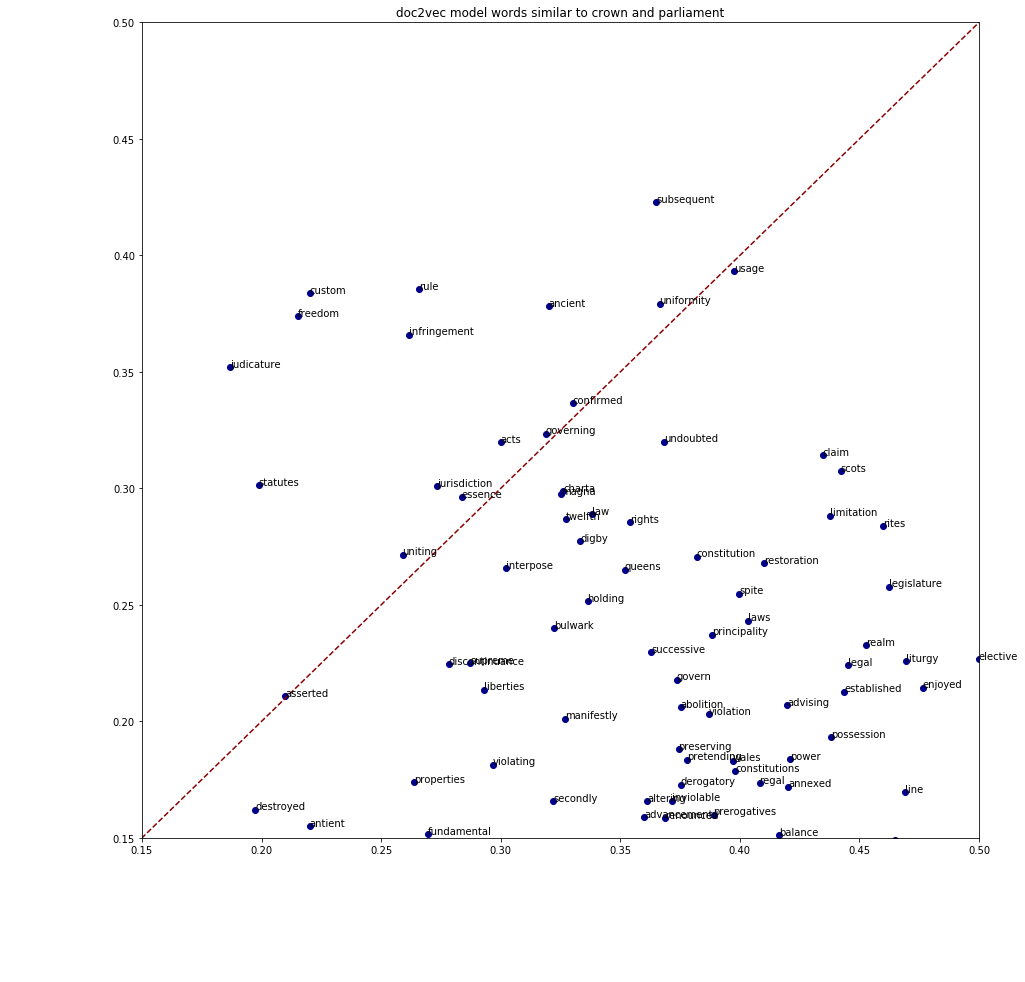

In [118]:
# zooming in
#same as before

#tell matplotlib to make a larger plot and define our axis object
plt.figure(figsize=(15,15))

#let's scatter our terms
plt.scatter(x, y, color='darkblue')

#this for loop marches through our list of tokens and adds an annotation to each value
for i in range(len(chosen_tokens)):
    plt.annotate(chosen_tokens[i], (x[i],y[i]))

#this plot places a line splitting the vector space in two
plt.plot([0, 1], [0, 1], linestyle='--', color='darkred')

#finally, let's 'zoom in' on the plot by defining limits to our x and y axis
plt.xlim(.15,.5)
plt.ylim(.15,.5)

plt.title('doc2vec model words similar to crown and parliament')
plt.show()



#### Now, to do the same with all documents.

Using the first and last of our labels.

In [159]:
subset_docs = []

for token, score in model.docvecs.most_similar(['1660_11','1739_2']):
    subset_docs.append(token)

In [160]:
#change the topn parameter in order to get more and more docs.
chosen_docs = model.docvecs.most_similar(subset_docs, topn=100)
chosen_docs = [doc for doc, similarity in chosen_docs]

In [161]:
x = [model.docvecs.similarity('1660_11', word) for word in chosen_docs]
y = [model.docvecs.similarity('1739_2', word) for word in chosen_docs]

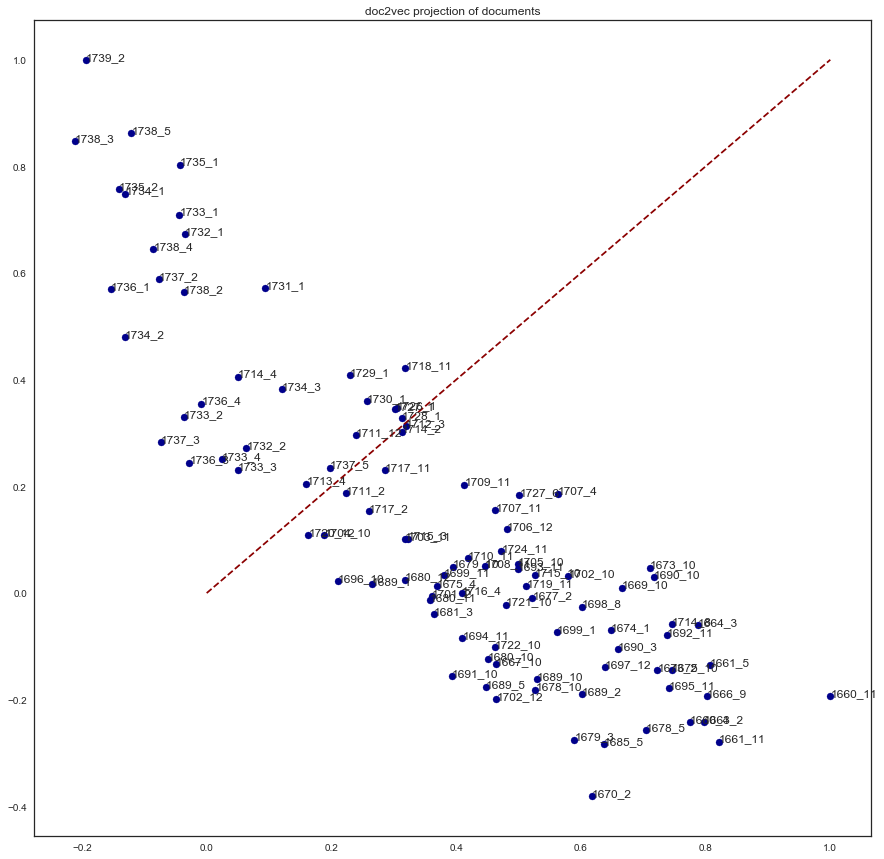

In [162]:
#tell matplotlib to make a larger plot and define our axis object
plt.figure(figsize=(15,15))


#let's scatter our terms
plt.scatter(x, y, color='darkblue')

#this for loop marches through our list of tokens and adds an annotation to each value
for i in range(len(chosen_docs)):
    plt.annotate(chosen_docs[i], (x[i],y[i]))

#this plot places a line splitting the vector space in two
plt.plot([0, 1], [0, 1], linestyle='--', color='darkred')

#finally, let's 'zoom in' on the plot by defining limits to our x and y axis
#plt.xlim(.2,.5)
#plt.ylim(.2,.5)

plt.title('doc2vec projection of documents')
plt.show()

#### 2.) T-sne projection of the documents with some k-means clustering

``model.docvecs`` holds our document vectors

In [119]:
# pop out our document vectors from the model
doc_vectors = model.docvecs.vectors_docs

In [120]:
from sklearn.cluster import KMeans

#five clusters for five monarchs
clusters = KMeans(n_clusters=5)
clusters.fit(doc_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

TSNEVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1a36723978>,
        classes=None, colormap=None, colors=None, decompose=None,
        decompose_by=None, labels=None, random_state=None)

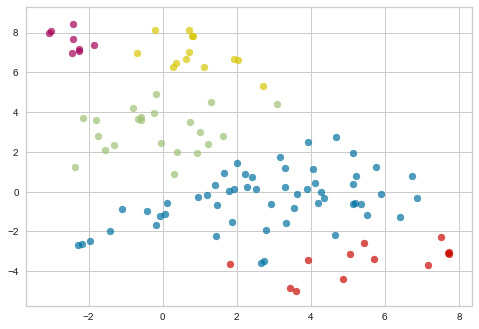

In [121]:
#from lab7
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit(doc_vectors, ["c{}".format(c) for c in clusters.labels_])

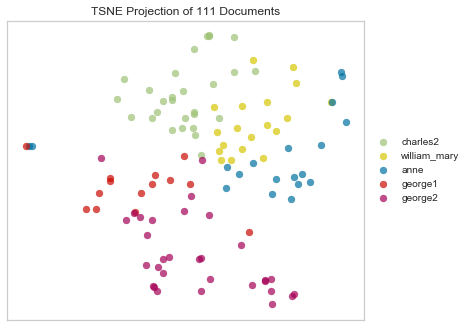

In [123]:
#same as above, but this time, color code by monarch

from yellowbrick.text import TSNEVisualizer

labels = df_texts['monarch'].tolist()

tsne = TSNEVisualizer()
tsne.fit(doc_vectors,labels)
tsne.poof()

#### Brief substantive interpretation:

1. Although not oriented the same way, we still have some distinct clusters.
2. There is roughly a linear movement, from charles2 to Will and Mary to Anne and then the Georges.

#### 3.) Lastly, is this legit? We can plot the cosine distance between doc2vec vectors.

$$\text{similarity} = \cos(\theta) = {\mathbf{A} \cdot \mathbf{B} \over \|\mathbf{A}\| \|\mathbf{B}\|} = \frac{ \sum\limits_{i=1}^{n}{A_i  B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{A_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{B_i^2}} }$$

<img src="images/cosine_sim.png", style="width: 500px"/>

- The cosine similarity of two matrices is one matrix by the other's transpose.
- If we take the docvecs vectors and multiple it by the transpose of itself, we calculate the cosine distance between each doc.
- For each of our embeddings vector, we're calculating the distance between each document on that axis.

In [194]:
# docvecs methods contains all of our vectors
# model.docvecs[0]

In [195]:
import sklearn.preprocessing as preprocessing
import numpy as np

def cosine_mat_similarities(mat):
    col_normed_mat = preprocessing.normalize(mat, axis=0)
    mat = np.matmul(col_normed_mat, col_normed_mat.T,)
    np.fill_diagonal(mat,0)
    return mat

In [196]:
d2v_cs = cosine_mat_similarities(pd.DataFrame(data=doc_vectors))

In [197]:
d2v_cs.shape

(111, 111)

In [198]:
#define a dataframe where both rows and columns are the doc labels
#and the data is the cosine similarities
d = pd.DataFrame(data=d2v_cs,
                 columns=list(df_texts.date),
                 index=list(df_texts.date))

In [199]:
#datacheck
d.head()

,1660_11,1660_4,1661_11,1661_5,1663_2,1664_11,1664_3,1665_10,1666_9,1667_10,...,1736_4,1737_2,1737_3,1737_5,1738_1,1738_2,1738_3,1738_4,1738_5,1739_2
1660_11,0.000000,0.388042,0.345069,0.330976,0.344608,0.231720,0.233735,0.267941,0.248439,0.200244,...,0.038963,-0.073592,-0.052695,0.091957,0.109410,-0.036224,-0.171785,-0.076932,-0.083850,-0.145301
1660_4,0.388042,0.000000,0.548117,0.547895,0.545613,0.319290,0.346071,0.392106,0.356012,0.301340,...,0.009518,-0.117384,-0.175749,0.086276,0.141515,0.003933,-0.210445,-0.296180,-0.252089,-0.244831
1661_11,0.345069,0.548117,0.000000,0.464762,0.512294,0.312230,0.323078,0.354982,0.344090,0.348980,...,0.025211,-0.100840,-0.085059,0.087022,0.063319,0.006211,-0.258697,-0.224006,-0.174320,-0.256802
1661_5,0.330976,0.547895,0.464762,0.000000,0.510957,0.307703,0.320079,0.367584,0.342173,0.317784,...,-0.059429,-0.004261,-0.209990,0.098116,0.112236,0.108630,-0.208393,-0.163120,-0.104591,-0.094663
1663_2,0.344608,0.545613,0.512294,0.510957,0.000000,0.306701,0.360928,0.346085,0.358888,0.368833,...,-0.014421,-0.060418,-0.067358,0.125618,0.058544,0.044152,-0.295245,-0.164605,-0.163991,-0.229034


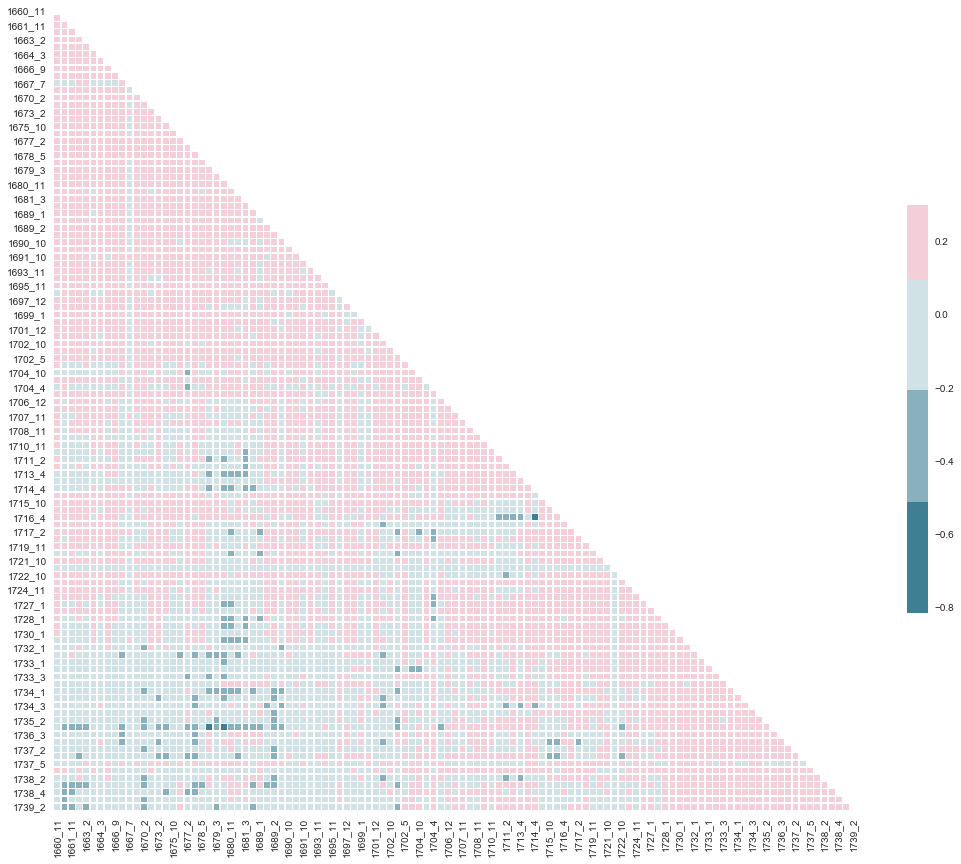

In [200]:
#seaborn is a attractive plotting system
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(d, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

cmap = sns.diverging_palette(220, 1, as_cmap=False)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(d, mask=mask, cmap=cmap, vmax=.3, center=0.1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [192]:
model.docvecs.most_similar(['1735_2'])

[('1735_1', 0.815828800201416),
 ('1739_2', 0.7580381631851196),
 ('1734_1', 0.7462586164474487),
 ('1732_1', 0.7311058044433594),
 ('1733_1', 0.7150543928146362),
 ('1736_1', 0.7076948881149292),
 ('1738_3', 0.6769965291023254),
 ('1737_2', 0.6660557985305786),
 ('1738_2', 0.6468157172203064),
 ('1731_1', 0.6390790939331055)]

In [193]:
model.docvecs.most_similar(['1680_11'])

[('1679_10', 0.8938820958137512),
 ('1680_10', 0.8680230975151062),
 ('1680_12', 0.7484412789344788),
 ('1681_3', 0.7402851581573486),
 ('1679_3', 0.6457435488700867),
 ('1685_5', 0.5487808585166931),
 ('1689_1', 0.5144649744033813),
 ('1675_4', 0.5111525058746338),
 ('1675_10', 0.5072087049484253),
 ('1663_2', 0.5017456412315369)]

#### Final substantive interpretation: 

1. Clearly there's some "autocorrelation" here.
2. Most documents just don't really relate to one another (and our PCA and T-sne projections show this.
3. However, this is picking up on some fundamental difference between the Whig Supremacy (after the 1745 Jacobite Rebellion leads to the suppression of the Tories) and the old-divine right of kings absolutist rule of Charles II.